# Выбор локации для скважины

Допустим, мы работаем в добывающей компании. Нужно решить, где бурить новую скважину.

Нам предоставлены пробы нефти в трёх регионах: в каждом 10 000 месторождений, где измерили качество нефти и объём её запасов. Требуется построить модель машинного обучения, которая поможет определить регион, где добыча принесёт наибольшую прибыль. Для анализа возможной прибыли и рисков воспользуемся техникой *Bootstrap.*

Шаги для выбора локации:

- В избранном регионе ищут месторождения, для каждого определяют значения признаков;
- Строят модель и оценивают объём запасов;
- Выбирают месторождения с самым высокими оценками значений. Количество месторождений зависит от бюджета компании и стоимости разработки одной скважины;
- Прибыль равна суммарной прибыли отобранных месторождений.

## Загрузка и подготовка данных

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
from sklearn.metrics import confusion_matrix
from sklearn.metrics import f1_score
from sklearn.metrics import accuracy_score

In [2]:
df_0 = pd.read_csv('/datasets/geo_data_0.csv')
df_1 = pd.read_csv('/datasets/geo_data_1.csv')
df_2 = pd.read_csv('/datasets/geo_data_2.csv')

In [3]:
df_0.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Data columns (total 5 columns):
id         100000 non-null object
f0         100000 non-null float64
f1         100000 non-null float64
f2         100000 non-null float64
product    100000 non-null float64
dtypes: float64(4), object(1)
memory usage: 3.8+ MB


In [4]:
df_0.head()

,id,f0,f1,f2,product
0,txEyH,0.705745,-0.497823,1.221170,105.280062
1,2acmU,1.334711,-0.340164,4.365080,73.037750
2,409Wp,1.022732,0.151990,1.419926,85.265647
3,iJLyR,-0.032172,0.139033,2.978566,168.620776
4,Xdl7t,1.988431,0.155413,4.751769,154.036647


In [5]:
len(df_0['id'].unique())

99990

In [6]:
df_1.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Data columns (total 5 columns):
id         100000 non-null object
f0         100000 non-null float64
f1         100000 non-null float64
f2         100000 non-null float64
product    100000 non-null float64
dtypes: float64(4), object(1)
memory usage: 3.8+ MB


In [7]:
df_1.head()

,id,f0,f1,f2,product
0,kBEdx,-15.001348,-8.276000,-0.005876,3.179103
1,62mP7,14.272088,-3.475083,0.999183,26.953261
2,vyE1P,6.263187,-5.948386,5.001160,134.766305
3,KcrkZ,-13.081196,-11.506057,4.999415,137.945408
4,AHL4O,12.702195,-8.147433,5.004363,134.766305


In [8]:
len(df_1['id'].unique())

99996

In [9]:
df_2.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Data columns (total 5 columns):
id         100000 non-null object
f0         100000 non-null float64
f1         100000 non-null float64
f2         100000 non-null float64
product    100000 non-null float64
dtypes: float64(4), object(1)
memory usage: 3.8+ MB


In [10]:
df_2.head()

,id,f0,f1,f2,product
0,fwXo0,-1.146987,0.963328,-0.828965,27.758673
1,WJtFt,0.262778,0.269839,-2.530187,56.069697
2,ovLUW,0.194587,0.289035,-5.586433,62.871910
3,q6cA6,2.236060,-0.553760,0.930038,114.572842
4,WPMUX,-0.515993,1.716266,5.899011,149.600746


In [11]:
len(df_2['id'].unique())

99996

Мы имеем 3 датасета, в каждом из которых содержится информация о 10 000 скважин. Пропусков в данных нет, но имеются дубликаты по номеру скважин (id). Правда, таких дубликатов всего доли процента.

## Обучение и проверка модели

Разделим данные на обучающие и тестовые выборки и обучим модели для каждого региона.

In [12]:
features_0 = df_0[['f0', 'f1', 'f2']]
target_0 = df_0['product']
features_1 = df_1[['f0', 'f1', 'f2']]
target_1 = df_1['product']
features_2 = df_2[['f0', 'f1', 'f2']]
target_2 = df_2['product']

In [13]:
features_train_0, features_valid_0, target_train_0, target_valid_0 = train_test_split(
    features_0, target_0, test_size=.25, random_state=123)
features_train_1, features_valid_1, target_train_1, target_valid_1 = train_test_split(
    features_1, target_1, test_size=.25, random_state=123)
features_train_2, features_valid_2, target_train_2, target_valid_2 = train_test_split(
    features_2, target_2, test_size=.25, random_state=123)

In [17]:
def model_regr(features, target):
    features_train, features_valid, target_train, target_valid = train_test_split(
        features, target, test_size=.25, random_state=123)
    model = LinearRegression()
    model.fit(features_train, target_train)
    predictions = model.predict(features_valid)
    print('Предсказанные средние запасы в регионе:', predictions.mean())
    mse = mean_squared_error(target_valid, predictions)
    print('RMSE модели', mse**.5)
    return model

In [18]:
# Проверим нулевой регион
print('Истинные средние запасы в регионе:', df_0['product'].mean())
model_0 = model_regr(features_0, target_0<div class="alert alert-block alert-warning">

Истинные средние запасы в регионе: 92.50000000000001
Предсказанные средние запасы в регионе: 92.54936189116309
RMSE модели 37.64786282376176


In [19]:
# Проверим первый регион
print('Истинные средние запасы в регионе:', df_1['product'].mean())
model_1 = model_regr(features_1, target_1)

Истинные средние запасы в регионе: 68.82500000000002
Предсказанные средние запасы в регионе: 69.28001860653976
RMSE модели 0.8954139804944304


In [20]:
# Проверим второй регион
print('Истинные средние запасы в регионе:', df_2['product'].mean())
model_2 = model_regr(features_2, target_2)

Истинные средние запасы в регионе: 95.00000000000004
Предсказанные средние запасы в регионе: 95.09859933591373
RMSE модели 40.12803006598514


Линейные модели почень хорошо предсказывают средние запасы в месторождении для всех трех районов, однако в нулевом и втором регионе большие среднеквадратичные отклонения целевого признака. Модель для первого района выдает очень маленькую ошибку RMSE

## Подготовка к расчёту прибыли

In [21]:
TOTAL_EXPENSES = 10000000000
OIL_PRICE = 450000
LOSES_LEVEL = 0.025

Посчитаем быджет на разработку одной скважины в регионе.

In [26]:
WELL_EXPENSES = TOTAL_EXPENSES / 200

In [27]:
ENOUGH_STOCK = WELL_EXPENSES / OIL_PRICE

In [28]:
ENOUGH_STOCK

111.11111111111111

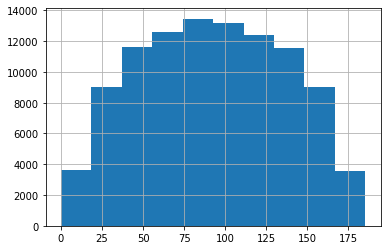

In [29]:
df_0['product'].hist()

In [30]:
df_0['product'].describe()

count    100000.000000
mean         92.500000
std          44.288691
min           0.000000
25%          56.497507
50%          91.849972
75%         128.564089
max         185.364347
Name: product, dtype: float64

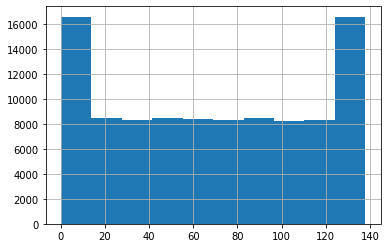

In [31]:
df_1['product'].hist()

In [32]:
df_1['product'].describe()

count    100000.000000
mean         68.825000
std          45.944423
min           0.000000
25%          26.953261
50%          57.085625
75%         107.813044
max         137.945408
Name: product, dtype: float64

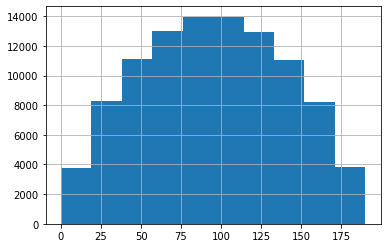

In [33]:
df_2['product'].hist()

In [34]:
df_2['product'].describe()

count    100000.000000
mean         95.000000
std          44.749921
min           0.000000
25%          59.450441
50%          94.925613
75%         130.595027
max         190.029838
Name: product, dtype: float64

Для того, чтобы окупилась разработка скважины, запасы нефти должны превышать 111 тыс. баррелей. Таких скважин всех меньше в первом районе (менее 25%). Более перспективные - нулевой и второй районы.

## Расчёт прибыли и рисков 

In [36]:
def profit(target, predicted):
    predicted = pd.Series(predicted, index=target.index)
    stock_of_wells = target[predicted.sort_values(ascending=False).index][:200].sum()
    return (stock_of_wells*OIL_PRICE - TOTAL_EXPENSES) / 1000000
    

In [37]:
df_0_sample = df_0.sample(n=500, random_state=1)
df_1_sample = df_1.sample(n=500, random_state=1)
df_2_sample = df_2.sample(n=500, random_state=1)

In [38]:
predicted_0 = model_0.predict(df_0_sample[['f0', 'f1', 'f2']])

In [39]:
profit_0 = profit(df_0_sample['product'], predicted_0)
profit_0

903.8510827823372

In [40]:
predicted_1 = model_1.predict(df_1_sample[['f0', 'f1', 'f2']])

In [41]:
profit_1 = profit(df_1_sample['product'], predicted_1)
profit_1

626.0328957964897

In [42]:
predicted_2 = model_2.predict(df_2_sample[['f0', 'f1', 'f2']])

In [43]:
profit_2 = profit(df_2_sample['product'], predicted_2)
profit_2

462.4590274405041

Совершенно неожиданно наибольшую прибыль предсказывает модель для нулевого региона (около 900 млн), далее идет первый регион - с самыми низкими суммарными и средними  запасами. Здесь прибыль составляет около 626 млн рублей. Для третьего района это значение почти на треть ниже - 462 млн. Возможно, в первом регионе аномально большая доля богатых нефтью месторождений, которые при случайном выборе 500 и дальнейшем прогнозировании 200 наиболее из них перспективных дают большую прибыль, поэтому он на втором месте несмотря на низкие суммарные запасы.

Теперь последовательно почитаем риски с помощью техники Bootstrap для каждого района.

In [54]:
def wells_predict(df, model):
    state = np.random.RandomState(12345)
    values = []
    loses = 0
    for i in range(1000):
        df_sample = df.sample(n=500, random_state=state)
        predicted = model.predict(df_sample[['f0', 'f1', 'f2']])
        profit_model = profit(df_sample['product'], predicted)
        values.append(profit_model)
    values = pd.Series(values)
    print("Средняя прибыль:", values.mean())
    print("95% доверительный интервал для прибыли:", values.quantile(0.025), ";", values.quantile(0.975))
    print("Вероятность убытков", (values < 0).mean())

In [55]:
# Прогноз для 0-го региона
wells_predict(df_0, model_0)

Средняя прибыль: 419.9430133621183
95% доверительный интервал для прибыли: -87.62683518190397 ; 908.0298339328756
Вероятность убытков 0.056


In [56]:
# Прогноз для 1-го региона
wells_predict(df_1, model_2)

Средняя прибыль: 452.0495129047899
95% доверительный интервал для прибыли: 39.56621898618857 ; 861.6660787133532
Вероятность убытков 0.014


In [57]:
# Прогноз для 2-го региона
wells_predict(df_2, model_2)

Средняя прибыль: 376.2954043362683
95% доверительный интервал для прибыли: -100.34080768746279 ; 866.4506422704231
Вероятность убытков 0.068


В нулевом и втором районах риски получить убытки составляют 6 и 7 процентов соответственно. При этом нижняя граница доверительного интервала прибыли отрицательная.  
Как это ни странно, самый перспективный район - первый. Здесь риск получить убытки менее 2%, 95%-й доверительный интервал распределения прибыли не содержит отрицательных значений, а ее среднее значение составляет 452 млн.